In [62]:
# Sarah loves music

from carabao.neurotron import Pulse,Terminal,Synapses,Monitor,toy
from carabao.util import repr
from carabao.screen import Screen
from numpy import array

#===================================================================================
# class: Neurotron
#===================================================================================

class Neurotron:
    """
    class Neurotron: full functionality
    >>> par = toy('sarah')
    >>> cell0 = Neurotron(k:=0,par,(10,3),'cell0')
    >>> print(cell0)
    """
    def __init__(self,k,par,sizes,name=None):
        self.k = k
        self.sizes = sizes
        self.name = name

        self.u = Pulse(0,1)
        self.q = Pulse(2,1)
        self.p = Pulse(1,7)
        self.y = Pulse(1,1)
        self.d = Pulse(0,3)
        self.b = Pulse(0,2)
        
        epar,dpar,ppar = par

        self.excite  = Terminal(epar.w[k],epar.theta,'excite')
        self.excite.synapses = Synapses(epar.k[k],epar.p[k],epar.eta)

        self.depress = Terminal(dpar.w[k],dpar.theta,'depress')
        self.depress.synapses = Synapses(dpar.g[k],dpar.p[k],dpar.eta)
    
        self.predict = Terminal(ppar.W[k],ppar.theta,'predict')
        self.predict.synapses = Synapses(ppar.K[k],ppar.P[k],ppar.eta)

    def __call__(self,y,log=None):
        def _or(x,y): return min(x+y,1)
        def _not(x): return (1-x)
        def _log(topic,k):
            if log is not None:
                return "%s%g:" % (topic,k)
            return None
            
        nc,nf = self.sizes; k = self.k
        c = y[:nc];  f = y[nc:nc+nf]
        
        if log is not None:
           print("\nf:",f,", c:",c)

        _y = self.y.out()
        _u = self.excite(f,_log('=> excite-',k))
        u = self.u(_u,_log(' - u',k))
        q = self.q(_u,_log(' - q',k))

        _s = self.predict(c,_log('=> predict-',k))
        p = self.p(_s,_log(' - p',k))
        
        _d = self.depress(c,_log('=> depress-',k))
        _b = _not(_d) * q
        b = self.b(_b,_log(' - b',k))

        _y = _or(u*p,q*b)
        #print(" - y%g = %g*%g || %g*%g =" % (k,u,p,q,b),_y) 
        y[k] = self.y(_y,_log(' - y',k))

        #if log is not None:
        #   print("y = [c,f]:",[y[:nc],y[nc:nc+nf]])
        return y

    def __repr__(self):
        #state = "), <updy> = <%g%g%g%g>" % (self.u,self.p,self.d,self.y)
        name = self.name if self.name is not None else ''
        return "Neurotron('%s',%g)"% (name,self.k) + ""

#===========================================================================
# class Cells
#===========================================================================

class Cells:
    def __init__(self,n,par,sizes,verbose=0):
        self.verbose = verbose
        self.cells = []
        for k in range(n):
            cell = Neurotron(k,par,sizes,'cell-%g'%k)
            self.cells.append(cell)
        self.u = [[] for k in range(n)];  
        self.q = [[] for k in range(n)];  
        self.p = [[] for k in range(n)];  
        self.y = [[] for k in range(n)];  
        self.b = [[] for k in range(n)];  

    def __call__(self,y,log=None):
        if log is not None:
            if self.verbose > 0: print("\n"+log)
            log = None if self.verbose == 0 else log
        for k in range(len(self.cells)):
            y = self.cells[k](y,log)

        for k in self.range():
            self.u[k].append(self[k].u.out())
            self.q[k].append(self[k].q.out())
            self.p[k].append(self[k].p.out())
            self.y[k].append(self[k].y.out())
            self.b[k].append(self[k].b.out())
        if (self.verbose > 0):
            self.log(y,log)
        return y

    def __getitem__(self,k):
        return self.cells[k]

    def range(self):
        return range(len(self.cells))
        
    def plot(self,j,tag=''):   # plot cell column at monitor location (*,j)
        for k in range(len(self.cells)):
            mon(self.cells[k],k,j)
        mon.xlabel(j,tag)

    def log(self,y,tag=None):
        print('\nsummary',tag)
        print("   u:",self.u)
        print("   q:",self.q)
        print("   p:",self.p)
        print("   b:",self.b)
        print("   y:",self.y)
        nc,nf = self[0].sizes
        print("y = [c,f]:",[y[:nc],y[nc:nc+nf]])
        
#=========================================================================
# helper: concatenate two Neurotron output lists
#=========================================================================

def cat(c,f):
    """
    cat(): concatenate two Neurotron output lists, return also sizes
    >>> y,sizes = cat(c,f)
    """
    sizes = (len(c),len(f))
    return (c+f,sizes)



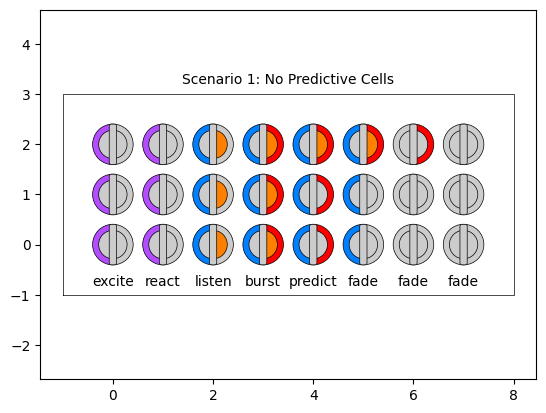

In [63]:
#===========================================================================
# Secario 1: No predictive cells 
#===========================================================================
par,token = toy('sarah');  epar,dpar,ppar = par
epar.p[2] = epar.p[1] = epar.p[0]             # overwrite => all the same
ppar.P[2][0] = ppar.P[1][0] = ppar.P[0][0]    # overwrite => all the same

y,sizes = cat(c:=[0,0,0],token['Sarah'])
cells = Cells(3,par,sizes,verbose=0)

mon = Monitor(3,8);  mon.title('Scenario 1: No Predictive Cells')

y = cells(y,'iteration 0 (excite)');   cells.plot(0,'excite')
y = cells(y,'iteration 1 (react)');    cells.plot(1,'react')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')
y = cells(y,'iteration 3 (burst)');    cells.plot(3,'burst')
y,sizes = cat(c:=[0,0,0],[0,0,0,0,0,0,0,0,0,0])
y = cells(y,'iteration 4 (predict)');  cells.plot(4,'predict')
y = cells(y,'iteration 5 (fade)');     cells.plot(5,'fade')
y = cells(y,'iteration 6 (fade)');     cells.plot(6,'fade')
y = cells(y,'iteration 7 (fade)');     cells.plot(7,'fade')

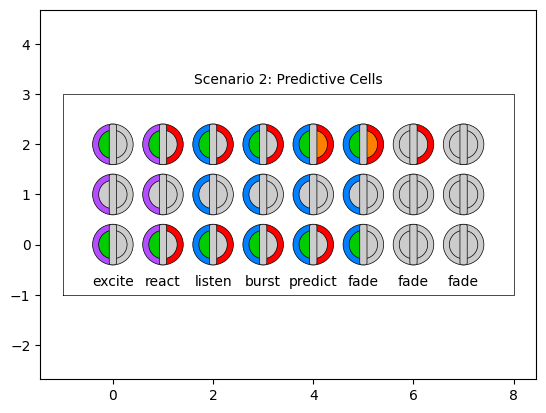

In [64]:
#===========================================================================
# Secario 2: some predictive cells 
#===========================================================================
par,token = toy('sarah');  epar,dpar,ppar = par
epar.p[2] = epar.p[1] = epar.p[0]             # overwrite => all the same
ppar.P[2][0] = ppar.P[1][0] = ppar.P[0][0]    # overwrite => all the same

y,sizes = cat(c:=[0,0,0],token['Sarah'])
cells = Cells(3,par,sizes,verbose=0)
cells[0].p.set(1)
cells[2].p.set(1)

mon = Monitor(3,8);  mon.title('Scenario 2: Predictive Cells')

y = cells(y,'iteration 0 (excite)');   cells.plot(0,'excite')
y = cells(y,'iteration 1 (react)');    cells.plot(1,'react')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')
y = cells(y,'iteration 3 (burst)');    cells.plot(3,'burst')
y,sizes = cat(c:=[0,0,0],[0,0,0,0,0,0,0,0,0,0])
y = cells(y,'iteration 4 (predict)');  cells.plot(4,'predict')
y = cells(y,'iteration 5 (fade)');     cells.plot(5,'fade')
y = cells(y,'iteration 6 (fade)');     cells.plot(6,'fade')
y = cells(y,'iteration 7 (fade)');     cells.plot(7,'fade')

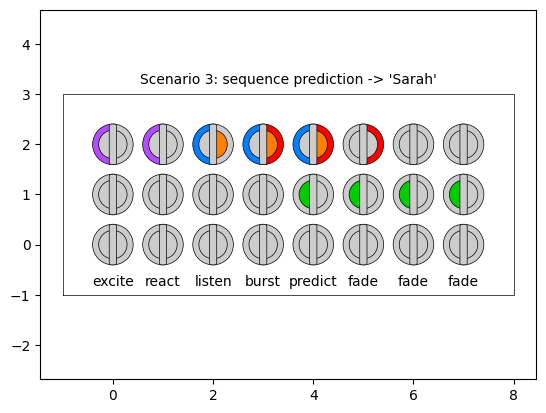

In [65]:
#===========================================================================
# Secario 3: sequence prediction -> 'Sarah'
#===========================================================================
par,token = toy('sarah')
#par[0].p[2] = par[0].p[1] = par[0].p[0] # overwrite => all the same

y,sizes = cat(c:=[0,0,0],token['Sarah'])
cells = Cells(3,par,sizes,verbose=0)

mon = Monitor(3,8);  mon.title("Scenario 3: sequence prediction -> 'Sarah'")

y = cells(y,'iteration 0 (excite)');   cells.plot(0,'excite')
y = cells(y,'iteration 1 (react)');    cells.plot(1,'react')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')
y,sizes = cat(c:=[0,0,0],[0,0,0,0,0,0,0,0,0,0])
y = cells(y,'iteration 3 (burst)');    cells.plot(3,'burst')
y = cells(y,'iteration 4 (predict)');  cells.plot(4,'predict')
y = cells(y,'iteration 5 (fade)');     cells.plot(5,'fade')
y = cells(y,'iteration 6 (fade)');     cells.plot(6,'fade')
y = cells(y,'iteration 7 (fade)');     cells.plot(7,'fade')

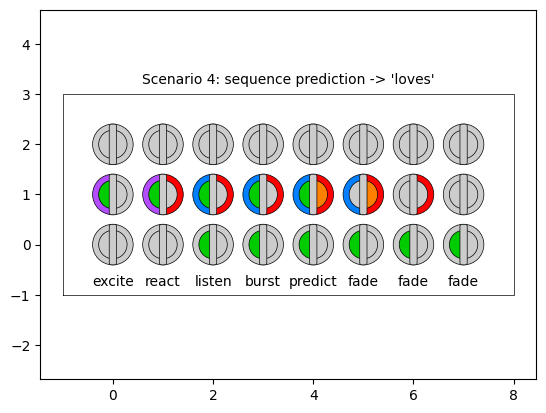

In [66]:
#===========================================================================
# Secario 4: sequence prediction -> 'loves'
#===========================================================================
par,token = toy('sarah')
#par[0].p[2] = par[0].p[1] = par[0].p[0] # overwrite => all the same

y,sizes = cat(c:=y[:3],token['loves'])
mon = Monitor(3,8);  mon.title("Scenario 4: sequence prediction -> 'loves'")

y = cells(y,'iteration 0 (excite)');   cells.plot(0,'excite')
y = cells(y,'iteration 1 (react)');    cells.plot(1,'react')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')
y = cells(y,'iteration 3 (burst)');    cells.plot(3,'burst')
y,sizes = cat(c:=[0,0,0],[0,0,0,0,0,0,0,0,0,0])
y = cells(y,'iteration 4 (predict)');  cells.plot(4,'predict')
y = cells(y,'iteration 5 (fade)');     cells.plot(5,'fade')
y = cells(y,'iteration 6 (fade)');     cells.plot(6,'fade')
y = cells(y,'iteration 7 (fade)');     cells.plot(7,'fade')

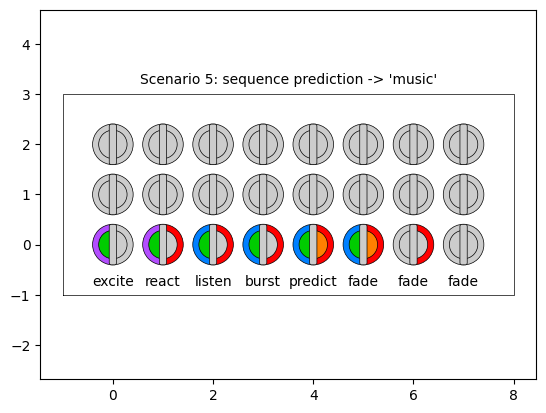

In [67]:
#===========================================================================
# Secario 5: sequence prediction -> 'music'
#===========================================================================
par,token = toy('sarah')
#par[0].p[2] = par[0].p[1] = par[0].p[0] # overwrite => all the same

y,sizes = cat(c:=y[:3],token['music'])
mon = Monitor(3,8);  mon.title("Scenario 5: sequence prediction -> 'music'")

y = cells(y,'iteration 0 (excite)');   cells.plot(0,'excite')
y = cells(y,'iteration 1 (react)');    cells.plot(1,'react')
y = cells(y,'iteration 2 (listen)');   cells.plot(2,'listen')
y = cells(y,'iteration 3 (burst)');    cells.plot(3,'burst')
y,sizes = cat(c:=[0,0,0],[0,0,0,0,0,0,0,0,0,0])
y = cells(y,'iteration 4 (predict)');  cells.plot(4,'predict')
y = cells(y,'iteration 5 (fade)');     cells.plot(5,'fade')
y = cells(y,'iteration 6 (fade)');     cells.plot(6,'fade')
y = cells(y,'iteration 7 (fade)');     cells.plot(7,'fade')